In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 12

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
# Confirmed Deaths
d_df = transform.IRD(min_confirmed=10, min_recovered=0, min_deaths=10)[2]
t_df, h_df, _ = transform.weather()
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>10)]
t_df = t_df.T[d_df.index.values].T
h_df = h_df.T[d_df.index.values].T

100%|██████████| 264/264 [00:25<00:00, 10.36it/s]


Weather data saved @ /data/COVID-19/covid19/data/weather


In [7]:
deaths = {}
temps = {}
hums = {}
max_days = 28
start_days = np.argmax((d_df.values>4),axis=1)
for i, country in enumerate(d_df.index):
    deaths[country] = d_df.T[country].values[start_days[i]:start_days[i]+max_days]
    temps[country] = t_df.T[country].values[start_days[i]:start_days[i]+max_days]
    hums[country] = h_df.T[country].values[start_days[i]:start_days[i]+max_days]

In [8]:
pops = transform.population()

Number of unmatched regions : 46
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


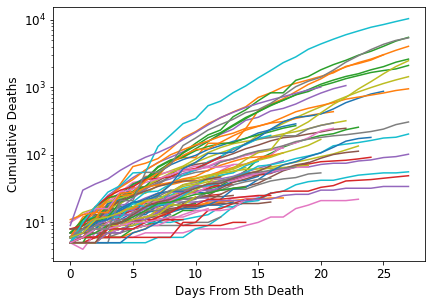

In [9]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for c in deaths.keys():
    plt.semilogy(deaths[c], label=c)
plt.ylabel('Cumulative Deaths')
plt.xlabel('Days From 5th Death')
plt.savefig('../plots/2.3_Deaths_Growth.png')
# plt.legend(ncol=3)

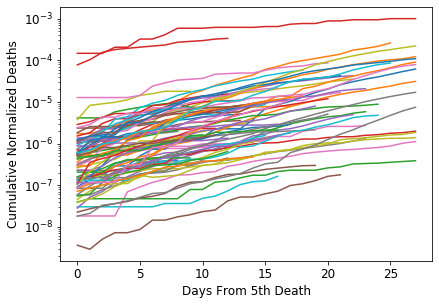

In [10]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for c in deaths.keys():
    try:
        plt.semilogy(deaths[c]/pops[c].values, label=c);
    except:
        pass
plt.ylabel('Cumulative Normalized Deaths')
plt.xlabel('Days From 5th Death')
plt.savefig('../plots/2.3_Deaths_Growth_Normed.png')
# plt.legend(ncol=3)

In [11]:
np.sum([len(deaths[c]) for c in deaths.keys()])

DeviceArray(1505, dtype=int32)

# Bayesian Model

For each country $i$ a forward model as follows is fitted

$$ D_i(t) = D^0_i(R_i + \alpha_i T + \beta_i H)^t$$

Each parameter ($D^0_i, R_i, \alpha_i, \beta_i$) has a parent distribution.

$D^0_i$ is the number of deaths at day 0.

$R_i$ is the base growth rate in cumulative deaths per day.

$\alpha_i$ is the temperature (measured in $^\circ$C) coefficient gving the temperature dependence of the overall growth rate.

$\beta_i$ is the humidity (relative humidity measured from 0 to 1) coefficient gving the temperature dependence of the overall growth rate.


In [12]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [13]:
def model():
    
    N = len(deaths)
    
    ############
    # Initial Infection Rate
    Di = normalHP('Di', 7.0, 3.0, N)
    # Infection Growth Rate
    GR = normalHP('GR', 1.3, 0.5, N)
    # Temperature Coefficient
    alpha = normalHP('alpha', 0.0, 0.1, N)
    # Humidity Coefficient
    beta = normalHP('beta', 0.0, 0.1, N)
    
    # Create likelihood for each country
    for i, country in enumerate(list(deaths.keys())[:N]):
        x = np.arange(len(deaths[country]))
        dead = deaths[country]
        temp = np.mean(temps[country])
        hum = np.mean(hums[country])
        # Likelihood
        numpyro.sample(country, 
                       dist.Poisson((Di[i]*(GR[i]+alpha[i]*temp+beta[i]*hum)**x)), # Exponential regression
                       obs=dead)
            

In [14]:
N = len(deaths)
init_params = {'Di_grp_mean': 1.0*np.ones((N_chains, 1)),
               'Di_grp_sigma': 0.5*np.ones((N_chains, 1)),
               'Di_ind': 1.0*np.ones((N_chains,N)),
               'GR_grp_mean': 1.33*np.ones((N_chains, 1)),
               'GR_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_ind': 1.33*np.ones((N_chains,N)), 
               'alpha_grp_mean': 0.0*np.ones((N_chains, 1)),
               'alpha_grp_sigma': 0.1**np.ones((N_chains, 1)),
               'alpha_ind': 0.0*np.ones((N_chains,N)),
               'beta_grp_mean': 0.0*np.ones((N_chains, 1)),
               'beta_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'beta_ind': 0.0*np.ones((N_chains,N))
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [ ]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(time()-s)

In [ ]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/2.3_TempHumidsamples.h5', 'w') as fp:
    for key in samples:
        fp[key] = samples[key]
mcmc.print_summary()

In [14]:
samples = {}
with h5py.File('../data/nb_samples/2.3_TempHumidsamples_old.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

KeyError: 'alpha_grp_mean'

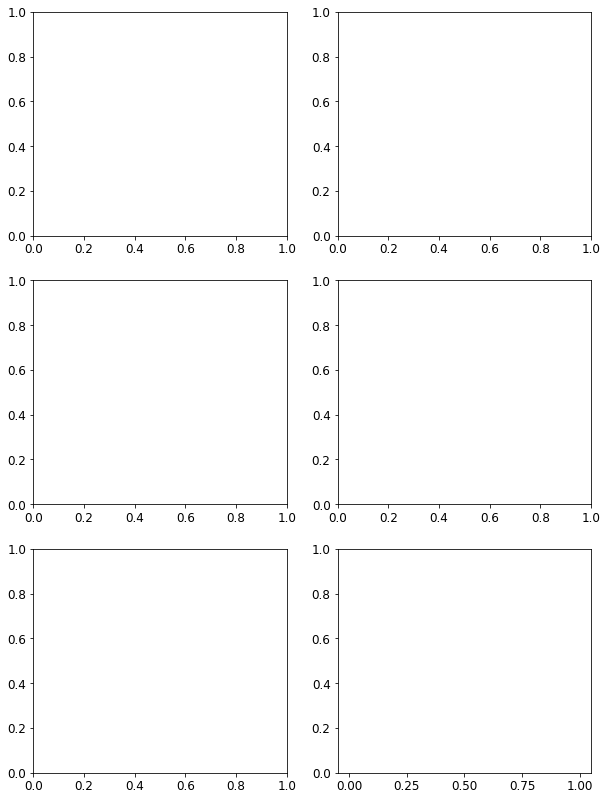

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(fig_scale*15, fig_scale*21))

plt.locator_params(axis='x', nbins=5)

sns.distplot(samples['alpha_grp_mean'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, ax=ax[0,0])
ax[0,0].vlines(np.mean(samples['alpha_grp_mean']), 0, norm.pdf(np.mean(samples['alpha_grp_mean']), *norm.fit(samples['alpha_grp_mean'])), 'r')
ax[0,0].set_title('Parent Distribution (Global)')
ax[0,0].set_xlabel(r'Temperature Coefficient of Growth Rate [$^\circ C^{-1} day^{-1}$]')


for i in range(len(samples['alpha_ind'][0])):
    sns.distplot(samples['alpha_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'red'}, ax=ax[0,1])
ax[0,1].set_title('Region Level Distributions')
ax[0,1].set_xlabel(r'Temperature Coefficients of Growth Rate [$^\circ C^{-1} day^{-1}$]')
        
sns.distplot(samples['beta_grp_mean'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, ax=ax[1,0])
ax[1,0].vlines(np.mean(samples['beta_grp_mean']), 0, norm.pdf(np.mean(samples['beta_grp_mean']), *norm.fit(samples['beta_grp_mean'])), 'r')
ax[1,0].set_title('Parent Distribution (Global)')
ax[1,0].set_xlabel(r'Humidity Coefficient of Growth Rate [$\%^{-1} day^{-1}$]')

for i in range(len(samples['beta_ind'][0])):
    sns.distplot(samples['beta_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'red'}, ax=ax[1,1])
ax[1,1].set_title('Region Level Distributions')
ax[1,1].set_xlabel(r'Humidity Coefficients of Growth Rate [$\%^{-1} day^{-1}$]')


sns.distplot(samples['GR_grp_mean'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, ax=ax[2,0])
ax[2,0].vlines(np.mean(samples['GR_grp_mean']), 0, norm.pdf(np.mean(samples['GR_grp_mean']), *norm.fit(samples['GR_grp_mean'])), 'r')
ax[2,0].set_title('Parent Distribution (Global)')
ax[2,0].set_xlabel(r'Death Growth Rate [$day^{-1}$]')


for i in range(len(samples['GR_ind'][0])):
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'red'}, ax=ax[2,1])
ax[2,1].set_title('Region Level Distributions')
ax[2,1].set_xlabel(r'Death Growth Rate [day$^{-1}$]')

plt.savefig('../plots/2.3_Temp_Humid_Deaths_Summary.png', dpi=200)

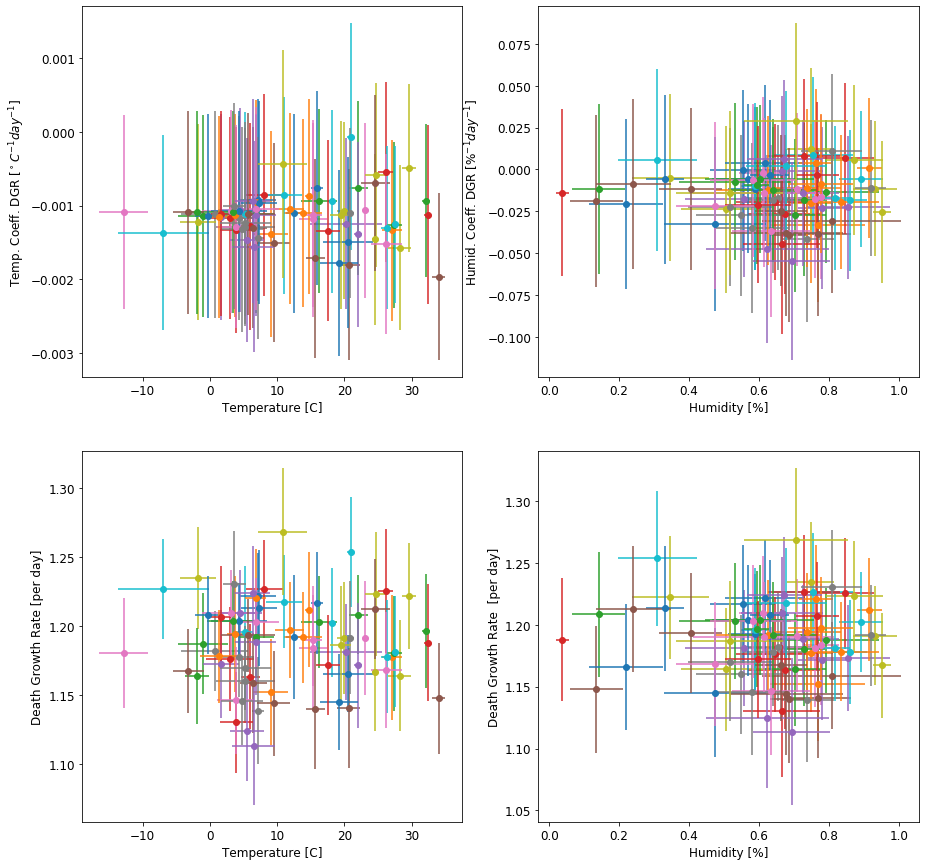

In [12]:
fig, ax = plt.subplots(2, 2,figsize=(fig_scale*15,fig_scale*15))

for i, c in enumerate(deaths.keys()):
    ax[0,0].errorbar(np.mean(temps[c]), np.mean(samples['alpha_ind'][:,i]),
                 xerr=np.std(temps[c]),
                 yerr=np.std(samples['alpha_ind'][:,i]), marker='o')
    
ax[0,0].set_xlabel('Temperature [C]')
ax[0,0].set_ylabel(r'Temp. Coeff. DGR [$^\circ C^{-1} day^{-1}$]')

for i, c in enumerate(deaths.keys()):
    ax[0,1].errorbar(np.mean(hums[c]), np.mean(samples['beta_ind'][:,i]),
                 xerr=np.std(hums[c]),
                 yerr=np.std(samples['beta_ind'][:,i]), marker='o')
    
ax[0,1].set_xlabel('Humidity [%]')
ax[0,1].set_ylabel(r'Humid. Coeff. DGR [$\%^{-1} day^{-1}$]')

for i, c in enumerate(deaths.keys()):
    ax[1,0].errorbar(np.mean(temps[c]), np.mean(samples['GR_ind'][:,i]),
                 xerr=np.std(temps[c]),
                 yerr=np.std(samples['GR_ind'][:,i]), marker='o')
    
ax[1,0].set_xlabel(r'Temperature [$^\circ$C]')
ax[1,0].set_ylabel('Death Growth Rate [per day]')

for i, c in enumerate(deaths.keys()):
    ax[1,1].errorbar(np.mean(hums[c]), np.mean(samples['GR_ind'][:,i]),
                 xerr=np.std(hums[c]),
                 yerr=np.std(samples['beta_ind'][:,i]), marker='o')
    
ax[1,1].set_xlabel('Humidity [%]')
ax[1,1].set_ylabel('Death Growth Rate  [per day]')

plt.savefig('../plots/2.3_Temp_Humid_Deaths_Variables.png', dpi=200)

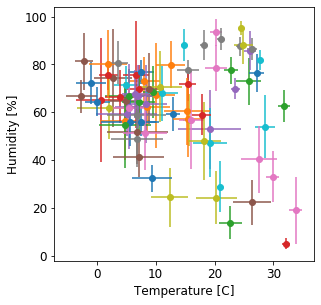

In [16]:
plt.figure(figsize=(fig_scale*7,fig_scale*7))
for i, c in enumerate(deaths.keys()):
    plt.errorbar(np.mean(temps[c]), np.mean(hums[c]),
                 xerr=np.std(temps[c]),
                 yerr=np.std(hums[c]), marker='o')
plt.xlabel('Temperature [C]')
plt.ylabel('Humidity [%]')
plt.savefig('../plots/2.3_Temp_vs_Humid.png', dpi=200)